# Performance

This notebook evaluates performance for a variety of product queries.

This is for queries related to product searches only. The data ingest workflow alreay includes built-in performance monitoring. Also, performance is most critical for user-facing queries where results need to be near-instantaneous.

In [1]:
%load_ext autoreload

In [2]:
%autoreload

import time

import matplotlib.pyplot as plt
import pandas as pd

import shared.query as q
import shared.format as format
import shared.reviews as rev
import shared.viz as viz

viz.set_style()
conn = q.connect()
pd.set_option('display.max_colwidth', 100)

In [3]:
def measure_query(query: str, params = None, description: str = None, include_results = False) -> pd.Series:
    description = description or query
    t = time.perf_counter()
    results = pd.read_sql_query(query, conn, params = params)
    elapsed = time.perf_counter() - t
    result = pd.Series(
        [description, elapsed, len(results)],
        index = ['description', 'time', 'results']
    )
    result['results_per_s'] = format.describe_number(result.results / result.time)
    if include_results:
        return (result, results)
    return result

## Data Setup

Let's begin by finding our popular products for the sake of stress testing:

In [4]:
popularity_query = """
SELECT p.id, p.title, p.creator, p.description, COUNT(*) AS ratings, category, subcategory
FROM review r JOIN product p ON r.product_id = p.id
GROUP BY r.product_id
ORDER BY ratings DESC LIMIT 10
"""

most_popular_performance, most_popular = measure_query(popularity_query, description = 'Most Popular Products', include_results = True)
most_popular

,id,title,creator,description,ratings,category,subcategory
0,B000IEZE3G,Harry Potter and The Sorcerer's Stone,J. K. Rowling,Celebrate 20 years of Harry Potter magic! Harry Potter has never even heard of Hogwarts when the...,6711,Books,Juvenile Fiction
1,B016WW10SA,25,Adele,,4354,Music,
2,B000ILIJE0,The Hobbit There and Back Again,John Ronald Reuel Tolkien,"The adventures of the well-to-do hobbit, Bilbo Baggins, who lived happily in his comfortable hom...",4331,Books,Adventure stories
3,B000NWU3I4,"The Hobbitt, or there and back again; illustrated by the author.",J. R. R. Tolkien,"Bilbo Baggins, a respectable, well-to-do hobbit, lives comfortably in his hobbit-hole until the ...",4316,Books,Fiction
4,B000Q032UY,The Hobbit or There and Back Again,J. R. R. Tolkien,Celebrating 75 years of one of the world's most treasured classics with an all new trade paperba...,4266,Books,Juvenile Fiction
5,B000GQG5MA,"The Hobbit; Or, There and Back Again",nan,None,4166,Books,nan
6,B000NDSX6C,The Hobbit,J. R. R. Tolkien,Celebrating 75 years of one of the world's most treasured classics with an all new trade paperba...,4118,Books,Juvenile Fiction
7,B000P1QRII,The Giver,Lois Lowry,"Given his lifetime assignment at the Ceremony of Twelve, Jonas becomes the receiver of memories ...",3770,Books,Juvenile Fiction
8,B00NEJ7MMI,That's Christmas To Me,Pentatonix,Used CD,3629,Music,
9,B0000YSH5G,Holes,Louis Sachar,#1 NEW YORK TIMES BESTSELLER • NEWBERY MEDAL WINNER • NATIONAL BOOK AWARD WINNER Dig deep in thi...,3512,Books,Juvenile Fiction


In [5]:
product_id = 'B000IEZE3G'
product = q.query("SELECT * FROM product WHERE id = ?", params = [product_id], conn = conn).iloc[0]
product

SELECT * FROM product WHERE id = ?: 1 results in 0.002 seconds


id                                                                                                         B000IEZE3G
title                                                                           Harry Potter and The Sorcerer's Stone
title_search                                                                             harrypotterandsorcerersstone
creator                                                                                                 J. K. Rowling
creator_search                                                                                              jkrowling
publisher                                                                                       Bloomsbury Publishing
description       Celebrate 20 years of Harry Potter magic! Harry Potter has never even heard of Hogwarts when the...
category                                                                                                        Books
subcategory                                             

## Database Schema
Let's pull up our database schema for reference to verify what indices we have in place:

In [6]:
pd.read_sql_query("SELECT * FROM sqlite_master ORDER BY tbl_name", conn)

,type,name,tbl_name,rootpage,sql
0,table,product,product,7,"CREATE TABLE product(\n id VARCHAR(36) PRIMARY KEY NOT NULL,\n title TEXT DEFAULT '',\n ..."
1,index,sqlite_autoindex_product_1,product,8,None
2,index,product_category_id,product,4837,"CREATE INDEX product_category_id ON product(category, id)"
3,table,review,review,2,"CREATE TABLE review(\n user_id VARCHAR(36),\n product_id VARCHAR(36) NOT NULL,\n\n titl..."
4,index,review_product_id,review,910296,CREATE INDEX review_product_id ON review(product_id)
5,index,review_user_id_product_id_review,review,199,"CREATE INDEX review_user_id_product_id_review ON review(user_id, product_id, rating, upvotes, do..."
6,table,sqlite_stat1,sqlite_stat1,3145,"CREATE TABLE sqlite_stat1(tbl,idx,stat)"
7,table,sqlite_stat4,sqlite_stat4,3220,"CREATE TABLE sqlite_stat4(tbl,idx,neq,nlt,ndlt,sample)"


## Throughput - User Reviews
A fundamental bottleneck for an SQL query is raw throughput limitations based on hardware and SQL. Let's begin with a foundation of establishing throughput limits.

In [7]:
sizes = [2, 100, 1_000, 3_000, 10_000, 30_000, 100_000]
def measure_throughput(query, description) -> pd.DataFrame:
    results = []
    for size in sizes:
        performance = measure_query("SELECT * FROM review LIMIT ?", params = [size], description = f'{size} {description}')
        results.append(performance)
    return pd.DataFrame.from_records(results).set_index('description')

measure_throughput("SELECT * FROM review LIMIT ?", 'Reviews')

,time,results,results_per_s
description,,,
2 Reviews,0.000856,2,2.3K
100 Reviews,0.003010,100,33.2K
1000 Reviews,0.016088,1000,62.2K
3000 Reviews,0.038956,3000,77.0K
10000 Reviews,0.096389,10000,103.7K
30000 Reviews,0.260526,30000,115.2K
100000 Reviews,0.809209,100000,123.6K


In [8]:
# The above results are very fast. Le'ts do another query that involves an index-based filter to simulate real-world conditions more closely:
measure_throughput("SELECT * FROM review ORDER BY user_id ASC LIMIT ?", 'Sorted Reviews')

,time,results,results_per_s
description,,,
2 Sorted Reviews,0.000634,2,3.2K
100 Sorted Reviews,0.000938,100,106.6K
1000 Sorted Reviews,0.003019,1000,331.2K
3000 Sorted Reviews,0.005359,3000,559.8K
10000 Sorted Reviews,0.019393,10000,515.6K
30000 Sorted Reviews,0.057723,30000,519.7K
100000 Sorted Reviews,0.198848,100000,502.9K


### Conclusion

Based on raw I/O limitations, **we can output hundreds of thousands of records per second**. Overall, this is sufficient for all practical purposes and is not a significant performance bottleneck.

However, when we have millions of records, we need to be mindful of full-table scans because even at a speed of hundreds of thousands of records per second, we'd expect a full table scan to be slow:


## Throughput - Full Table Scans

In [9]:
books = measure_query("SELECT * FROM product WHERE category = 'Books'", description = 'All Books')
print('fetched all books')

book_ids = measure_query("SELECT id FROM product WHERE category = 'Books'", description = 'All Book IDs')
print('fetched all book IDs')

authors = measure_query("SELECT DISTINCT(creator) FROM product WHERE category = 'Books'", description = 'All Authors')
print('fetched all authors')

albums = measure_query("SELECT * FROM product WHERE category = 'Music'", description = 'All Albums')
print('fetched all albums')

album_ids = measure_query("SELECT id FROM product WHERE category = 'Music'", description = 'All Album IDs')
print('fetched all album IDs')

artists = measure_query("SELECT DISTINCT(creator) FROM product WHERE category = 'Music'", description = 'All Artists')
print('fetched all artists')

product_ids_from_reviews = measure_query("SELECT DISTINCT(product_id) FROM review", description = 'Product IDs from reviews')
print('fetched all product ids')

# This result is noteworthy. Because we have over 2M unique users, enumerating them is slow even if retrieving only the ID and using an index.
user_ids_from_reviews = measure_query("SELECT DISTINCT(user_id) FROM review", description = 'User IDs from reviews')
print('fetched all user IDs from reviews')

# This result is noteworthy. The query is much faster than retrieving product IDs from reviews despite the additional join + comparison.
book_ids_from_reviews = measure_query("SELECT DISTINCT(product_id) FROM review r JOIN product p ON r.product_id = p.id WHERE category = 'Books'", description = 'Book IDs from reviews')
print('fetched all book IDs from reviews')

fetched all books
fetched all book IDs
fetched all authors
fetched all albums
fetched all album IDs
fetched all artists
fetched all product ids
fetched all user IDs from reviews
fetched all book IDs from reviews


In [10]:
scan_performance = pd.concat([
    books, book_ids, authors, albums, album_ids, artists, 
    product_ids_from_reviews, user_ids_from_reviews, book_ids_from_reviews
], axis = 1).T.sort_values(by = 'time', ascending = True)
scan_performance

,description,time,results,results_per_s
1,All Book IDs,0.068444,212397,3.1M
4,All Album IDs,0.249571,768224,3.1M
2,All Authors,0.473208,127273,269.0K
8,Book IDs from reviews,0.6724,212397,315.9K
5,All Artists,1.697386,228446,134.6K
0,All Books,1.998564,212397,106.3K
6,Product IDs from reviews,3.776732,980311,259.6K
3,All Albums,5.074348,768224,151.4K
7,User IDs from reviews,11.782991,2778917,235.8K


### Conclusion

Full table scans result in performance that is acceptable for EDA but not for user-facing queries.

Interestingly, enumerating all product IDs is an exception and performs at realtime speeds even with a real-world-sized dataset.

## Table Join

Joining products and reviews is a frequent operation. Let's benchark how long it takes to join products and reviews:

In [11]:
measure_query("SELECT 1 FROM review r JOIN product p ON r.product_id = p.id", description = 'review/product join')

description      review/product join
time                        7.294501
results                      7412044
results_per_s                   1.0M
dtype: object

In [12]:
measure_query("SELECT 1 FROM review r LEFT JOIN product p ON r.product_id = p.id", description = 'review/product join - left')

description      review/product join - left
time                               5.799438
results                             7412044
results_per_s                          1.3M
dtype: object

In [13]:
measure_query("SELECT 1 FROM review r RIGHT JOIN product p ON r.product_id = p.id", description = 'review/product join - right')

description      review/product join - right
time                               10.419358
results                              7412354
results_per_s                         711.4K
dtype: object

In [14]:
measure_query("SELECT 1 FROM review r INNER JOIN product p ON r.product_id = p.id", description = 'review/product join - inner')

description      review/product join - inner
time                                7.107874
results                              7412044
results_per_s                           1.0M
dtype: object

This is very slow! It looks like full table joins are prohibitive, and efficient joins generally rely on filters:

In [15]:
measure_query("SELECT 1 FROM review r JOIN product p ON r.product_id = p.id WHERE category = 'Books'", description = 'review/product join - books')

description      review/product join - books
time                                1.375244
results                              2564505
results_per_s                           1.9M
dtype: object

In [16]:
measure_query("SELECT 1 FROM review r JOIN product p ON r.product_id = p.id WHERE creator_search = 'drseuss'", description = 'review/product join - author')

description      review/product join - author
time                                   1.5461
results                                  2077
results_per_s                            1.3K
dtype: object

In [17]:
measure_query("""
SELECT product_id, COUNT(*) AS reviews
FROM review r JOIN product p ON r.product_id = p.id 
WHERE creator_search = 'drseuss' 
GROUP BY product_id
ORDER BY reviews DESC LIMIT 10
""", description = 'review/product join - author + best')

description      review/product join - author + best
time                                         6.83709
results                                           10
results_per_s                                   1.46
dtype: object

## Review Retrieval

Getting reviews similar to a product is a demonstrable bottleneck for our recommendation pipeline. Let's look at performance details for various ways to retrieve related reviews.

In [18]:
# Getting reviews for just the target product is very fast
performance_reviews, reviews = measure_query(
    "SELECT * FROM review WHERE product_id = ?" , [product_id],
    description = "Reviews for product", include_results = True
)
performance_reviews

description      Reviews for product
time                        0.059819
results                         6711
results_per_s                 112.2K
dtype: object

In [ ]:
# This query - the initial model for getting related reviews - is slow though. Let's find out why
related_reviews_query = """
SELECT * FROM review WHERE user_id IN (
    SELECT DISTINCT(user_id) FROM review WHERE product_id = ?
)
"""
performance_related_reviews, related_reviews = measure_query(related_reviews_query, [product_id], "Related reviews - nested query", include_results = True)
performance_related_reviews


description      Related reviews - nested query
time                                   8.194383
results                                   49380
results_per_s                              6.0K
dtype: object

In [20]:
rev.review_summary(related_reviews, "Related Products")

reviews     49380
users        3663
products    21570
Name: Related Products, dtype: int64

In [21]:
q.query(f"EXPLAIN QUERY PLAN {related_reviews_query}", conn, params = [product_id])

EXPLAIN QUERY PLAN 
SELECT * FROM review WHERE user_id IN (
    SELECT DISTINCT(user_id) FROM review WHERE product_id = ?
)
: 4 results in 0.001 seconds


,id,parent,notused,detail
0,3,0,0,SEARCH review USING INDEX review_user_id_product_id_review (user_id=?)
1,7,0,0,LIST SUBQUERY 1
2,11,7,0,SEARCH review USING INDEX review_product_id (product_id=?)
3,25,7,0,USE TEMP B-TREE FOR DISTINCT


The query appears efficient, making use of indices each step of the way. However, the final duration is quite long. Let's dig deeper by inspecting the inner query only.

In [22]:
performance_related_users, related_users = measure_query("""
SELECT DISTINCT(user_id) FROM review WHERE product_id = ?
""", [product_id], 'Get related users', include_results = True)
performance_related_users

description      Get related users
time                      0.020789
results                       3664
results_per_s               176.2K
dtype: object

The inner query is very fast. Our database is bottlenecked by retrieving reviews matching one of 3K+ users. Let's find out more about this limitation and what we can do about it.

In [23]:
product_reviews = q.get_reviews(product_id, conn)
product_reviews = product_reviews[product_reviews.upvotes >= product_reviews.downvotes]
users = product_reviews.user_id.dropna().unique()
print(f'{len(users)} unique users')


get_reviews: 6711 results in 0.016 seconds
3205 unique users


In [71]:
values = ','.join('?' * len(users))
params = users
rating_query = f"""
SELECT product_id, user_id, rating
FROM review WHERE user_id IN ({values})
"""
q.query(rating_query, conn, params, query_description = f"ratings by {len(users)} users")

ratings by 3205 users: 44985 results in 0.052 seconds


,product_id,user_id,rating
0,B000IEZE3G,A00538832OF17R8Q8JHTB,5
1,B000IEZE3G,A01023015VSQI0VE22HU,5
2,B000IEZE3G,A03391331MFHD3H31AEN3,5
3,B000IEZE3G,A0758433116TZO7LGNAGK,4
4,B000IEZE3G,A07685512S30H6VZLCUE9,5
...,...,...,...
44980,B000IEZE3G,AZXQKAMHK35PA,5
44981,B000JK14VK,AZXQKAMHK35PA,3
44982,B000K26U2A,AZXQKAMHK35PA,5
44983,B000NXIA1A,AZXQKAMHK35PA,4


This result is significant. The reason for the slow performance on finding related reviews is the lack of a covering index:

Update: the above query was originally slow, but adding a covering index on all of the selected fields (user id + product id + rating) improved performance from over 4 seconds down to a fraction of a second.

In [ ]:
# This query can filter by product and user review count as part of the SQL query.
# But it does not improve performance compared to post-filtering with Pandas, so let's keep the existing algorithm.
rating_query = f"""
WITH user_reviews AS (
    SELECT product_id, user_id, rating, COUNT(*) OVER(PARTITION BY user_id) AS user_reviews, COUNT(*) OVER (PARTITION BY product_id) AS product_reviews
    FROM review WHERE user_id IN ({values})
)
SELECT *, user_reviews + product_reviews AS all_reviews FROM user_reviews
--ORDER BY all_reviews DESC LIMIT 1000
ORDER BY product_reviews DESC 
"""
q.query(rating_query, conn, params, query_description = f"ratings by {len(users)} users")

ratings by 3205 users: 44985 results in 0.506 seconds


,product_id,user_id,rating,user_reviews,product_reviews,all_reviews
0,B000IEZE3G,A00538832OF17R8Q8JHTB,5,1,3205,3206
1,B000IEZE3G,A01023015VSQI0VE22HU,5,1,3205,3206
2,B000IEZE3G,A03391331MFHD3H31AEN3,5,1,3205,3206
3,B000IEZE3G,A0758433116TZO7LGNAGK,4,1,3205,3206
4,B000IEZE3G,A07685512S30H6VZLCUE9,5,1,3205,3206
...,...,...,...,...,...,...
44980,B000K0EOHK,AZSV99SDJC242,4,77,1,78
44981,0891346538,AZXQKAMHK35PA,3,21,1,22
44982,0891347259,AZXQKAMHK35PA,3,21,1,22
44983,B0007J1P8A,AZXQKAMHK35PA,5,21,1,22


## Batch Record Retrieval

Fetching records based on one of many ID values - for example, fetching all reviews matching one of thousands of users - is a common pattern. How performant and scalable is this pattern though? Is there a point at which it is more efficient to use a subquery versus binding to a large set of parameters?

In [25]:
sizes = [2, 10, 100, 300, 1_000, 3_000]
results = []
for size in sizes:
    performance = measure_query("""
    SELECT * FROM review WHERE user_id IN (
        SELECT DISTINCT(user_id) FROM review LIMIT ?
    )
    """, [size], f"reviews by {size} users - nested query")
    print(size)
    results.append(performance)
nested_query_results = pd.DataFrame.from_records(results)
nested_query_results

2
10
100
300
1000
3000


,description,time,results,results_per_s
0,reviews by 2 users - nested query,0.455467,1,2.20
1,reviews by 10 users - nested query,0.013845,13,938.96
2,reviews by 100 users - nested query,0.037140,175,4.7K
3,reviews by 300 users - nested query,0.069200,546,7.9K
4,reviews by 1000 users - nested query,0.202881,1820,9.0K
5,reviews by 3000 users - nested query,0.560743,6066,10.8K


The above result is counterintuitive. Even though the query is conceptually identical to related_reviews_query, it executes over 10x as quickly.

Let's try the experiment again with parameterized queries:

In [26]:
results = []
unique_user_ids = related_reviews.user_id
for size in sizes:
    params = ','.join('?' * size)
    ids = unique_user_ids[:size]
    performance = measure_query(f"""
    SELECT * FROM review WHERE user_id IN ({params})
    """, ids, f"reviews by {size} users - parameter binding")
    print(size)
    results.append(performance)
nested_query_results = pd.DataFrame.from_records(results)
nested_query_results

2
10
100
300
1000
3000


,description,time,results,results_per_s
0,reviews by 2 users - parameter binding,0.001765,2,1.1K
1,reviews by 10 users - parameter binding,0.001123,10,8.9K
2,reviews by 100 users - parameter binding,0.011595,105,9.1K
3,reviews by 300 users - parameter binding,0.029277,332,11.3K
4,reviews by 1000 users - parameter binding,0.079427,1004,12.6K
5,reviews by 3000 users - parameter binding,0.791321,6437,8.1K


The above approach - unlike the nested query simulation - is identical to real-world applications and produces results quickly.

Performance degrades substantially after 1_000 users - a more-than-reasonable maximum window for a recommender algorithm.

As a final exploration into batch retrievals, let's find out the maximum number of products we can batch-fetch quickly:

In [27]:
# Note: 300K bindings breaks sqlite's limits on parameter bindings, so 250K is as high as we will go.
sizes = [500, 1_000, 3_000, 10_000, 30_000, 50_000, 100_000, 150_000, 250_000]
results = []
for size in sizes:
    performance = measure_query(f"""
    SELECT * FROM product WHERE id IN (SELECT id FROM product LIMIT ?)
    """, [size], f"{size} products - nested query")
    results.append(performance)
nested_query_results = pd.DataFrame.from_records(results)
nested_query_results

,description,time,results,results_per_s
0,500 products - nested query,0.006344,500,78.8K
1,1000 products - nested query,0.004033,1000,247.9K
2,3000 products - nested query,0.012875,3000,233.0K
3,10000 products - nested query,0.039911,10000,250.6K
4,30000 products - nested query,0.118484,30000,253.2K
5,50000 products - nested query,0.180123,50000,277.6K
6,100000 products - nested query,0.379870,100000,263.2K
7,150000 products - nested query,0.774927,150000,193.6K
8,250000 products - nested query,2.066729,250000,121.0K


In [28]:
results = []
product_ids = pd.read_sql('SELECT id FROM product', conn)['id']
print('got product ids')
for size in sizes:
    params = ','.join('?' * size)
    ids = product_ids[:size]
    performance = measure_query(f"""
    SELECT * FROM product WHERE id IN ({params})
    """, ids, f"{size} products - parameter binding")
    results.append(performance)
param_binding_results = pd.DataFrame.from_records(results)
param_binding_results

got product ids


,description,time,results,results_per_s
0,500 products - parameter binding,0.005346,500,93.5K
1,1000 products - parameter binding,0.005257,1000,190.2K
2,3000 products - parameter binding,0.017353,3000,172.9K
3,10000 products - parameter binding,0.049427,10000,202.3K
4,30000 products - parameter binding,0.137787,30000,217.7K
5,50000 products - parameter binding,0.301041,50000,166.1K
6,100000 products - parameter binding,0.452543,100000,221.0K
7,150000 products - parameter binding,1.397778,150000,107.3K
8,250000 products - parameter binding,1.219844,250000,204.9K


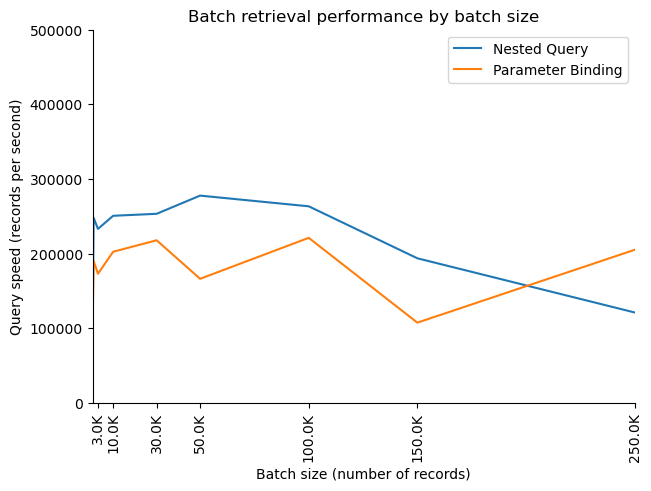

In [29]:
x = sizes
plt.plot(x, nested_query_results.results / nested_query_results.time, label = 'Nested Query')
plt.plot(x, param_binding_results.results / param_binding_results.time, label = 'Parameter Binding')
plt.gca().set(
    xlabel = 'Batch size (number of records)',
    ylabel = 'Query speed (records per second)',
    title = 'Batch retrieval performance by batch size',
    xlim = (500, 250_000), ylim = (0, 500_000),
    xticks = x[2:], xticklabels = map(format.describe_number, x[2:])
)
plt.xticks(rotation = 90)
plt.legend()

### Conclusion

Parameter binding performs remarkably well even for very large numbers of parameters, outclassing subqueries for almost every batch size. Our underlying database has a limit of about a quarter million parameters for parameter binding, which is more than enough for all of our applications.

## Popularity Search
Popularity searches such as the one at the top of this notebook are quite slow - fast enough for EDA, but not for user applications. Can we make a popularity search at user-facing speeds?

Let's pull up stats on the original search again:

In [30]:
pd.DataFrame([popularity_query])

,0
0,"\nSELECT p.id, p.title, p.creator, p.description, COUNT(*) AS ratings, category, subcategory\nFR..."


In [31]:
most_popular_performance

description      Most Popular Products
time                         21.117695
results                             10
results_per_s                     0.47
dtype: object

In [32]:
pd.read_sql("EXPLAIN QUERY PLAN " + popularity_query, conn)

,id,parent,notused,detail
0,10,0,0,SCAN r USING COVERING INDEX review_product_id
1,12,0,0,SEARCH p USING INDEX sqlite_autoindex_product_1 (id=?)
2,54,0,0,USE TEMP B-TREE FOR ORDER BY


In contrast, a real user-facing popularity search is very fast:

In [87]:
album_search_query = """
SELECT p.*, COUNT(*) AS reviews
FROM review r JOIN product p ON r.product_id = p.id 
WHERE title_search = 'pleasureprinciple'
GROUP BY product_id ORDER BY reviews DESC
"""
results = q.query(album_search_query, conn = conn, query_description =  'Album search')
results

Album search: 8 results in 0.009 seconds


,id,title,title_search,creator,creator_search,publisher,description,category,subcategory,release_date,reviews
0,B000006NTW,The Pleasure Principle,pleasureprinciple,Gary Numan,garynuman,,"Digitally remastered! Debut 1979 solo album, reissued with 7 rare BONUS tracks and detailed line...",Music,,"April 30, 2006",80
1,B015GH01ZA,The Pleasure Principle,pleasureprinciple,Gary Numan,garynuman,,Vinyl LP pressing. The most popular of all the Gary Numan albums is undeniably 1979's The Pleasu...,Music,,"October 15, 2015",15
2,B00D6ZCTX2,Pleasure Principle,pleasureprinciple,Parlet,parlet,,"Of George Clinton's two girl groups, The Brides of Funkenstein commanded the lioness' share of a...",Music,,"June 5, 2013",8
3,B00005MHPK,The Pleasure Principle,pleasureprinciple,Treat,treat,,Wellness version.,Music,,"February 11, 2007",4
4,B07Y61RTHV,The Pleasure Principle,pleasureprinciple,Gary Numan,garynuman,,Vinyl records and Compact Discs,Music,,"December 8, 2015",2
5,B0013FSXVY,The Pleasure Principle,pleasureprinciple,Gary Numan,garynuman,,VINYL LP- ATCO RECORDS- 1979-STEREO,Music,,"March 28, 2008",2
6,B002DM3Y10,The Pleasure Principle,pleasureprinciple,Janet Jackson,janetjackson,,,Music,,"February 11, 2011",1
7,B001TOZYN4,Pleasure Principle,pleasureprinciple,Parlet,parlet,,Pleasure Principle,Music,,"February 22, 2009",1


In [88]:
album_search_query_fuzzy = """
SELECT p.*, COUNT(*) AS reviews
FROM review r JOIN product p ON r.product_id = p.id 
WHERE title_search LIKE '%pleasureprinciple%'
GROUP BY product_id ORDER BY reviews DESC
"""
results = q.query(album_search_query_fuzzy, conn = conn, query_description =  'Album search')
results

Album search: 16 results in 18.037 seconds


,id,title,title_search,creator,creator_search,publisher,description,category,subcategory,release_date,reviews
0,B000006NTW,The Pleasure Principle,pleasureprinciple,Gary Numan,garynuman,,"Digitally remastered! Debut 1979 solo album, reissued with 7 rare BONUS tracks and detailed line...",Music,,"April 30, 2006",80
1,B015GH01ZA,The Pleasure Principle,pleasureprinciple,Gary Numan,garynuman,,Vinyl LP pressing. The most popular of all the Gary Numan albums is undeniably 1979's The Pleasu...,Music,,"October 15, 2015",15
2,B00D6ZCTX2,Pleasure Principle,pleasureprinciple,Parlet,parlet,,"Of George Clinton's two girl groups, The Brides of Funkenstein commanded the lioness' share of a...",Music,,"June 5, 2013",8
3,B002GKC34I,The Pleasure Principle (Expanded Edition),pleasureprincipleexpandededition,Gary Numan,garynuman,,"Gary's Replicas had already hit UK #1, but this 1980 LP made him a star in the U.S. as well. His...",Music,,"July 31, 2009",7
4,B0007EI1EQ,Beyond the pleasure principle,beyondpleasureprinciple,Sigmund Freud,sigmundfreud,Courier Corporation,Controversial 1920 publication expands Freud's theoretical approach to include the death drive. ...,Books,Psychology,2015-02-18,6
5,B00005MHPK,The Pleasure Principle,pleasureprinciple,Treat,treat,,Wellness version.,Music,,"February 11, 2007",4
6,B000W48PHY,Gary Numan - The Pleasure Principle,garynumanpleasureprinciple,Gary Numan,garynuman,,,Music,,"September 18, 2007",4
7,B0013FSXVY,The Pleasure Principle,pleasureprinciple,Gary Numan,garynuman,,VINYL LP- ATCO RECORDS- 1979-STEREO,Music,,"March 28, 2008",2
8,B004EFN6D0,Pleasure Principle Live,pleasureprinciplelive,Gary Numan,garynuman,,Gary Numan's The Pleasure Principle was recently nominated as No 5 in Mojo's Best Synth Pop albu...,Music,,"December 1, 2010",2
9,B07Y61RTHV,The Pleasure Principle,pleasureprinciple,Gary Numan,garynuman,,Vinyl records and Compact Discs,Music,,"December 8, 2015",2


In [62]:
pd.read_sql_query('EXPLAIN QUERY PLAN ' + album_search_query, conn)

,id,parent,notused,detail
0,9,0,0,SEARCH p USING INDEX product_title_search (title_search=?)
1,14,0,0,SEARCH r USING COVERING INDEX review_product_id (product_id=?)
2,18,0,0,USE TEMP B-TREE FOR GROUP BY
3,73,0,0,USE TEMP B-TREE FOR ORDER BY


Clearly the performance boost is from filtering out most products before executing an expensive join. But how can we optimize popularity for a wider search?

Let's try using only review data to avoid the expensive join:

In [66]:
review_popularity_query = """
SELECT product_id, COUNT(*) AS reviews
FROM review r
GROUP BY product_id
ORDER BY reviews DESC LIMIT 10
"""

q.query(review_popularity_query, conn)


SELECT product_id, COUNT(*) AS reviews
FROM review r
GROUP BY product_id
ORDER BY reviews DESC LIMIT 10
: 10 results in 3.737 seconds


,product_id,reviews
0,B000IEZE3G,6711
1,B016WW10SA,4354
2,B000ILIJE0,4331
3,B000NWU3I4,4316
4,B000Q032UY,4266
5,B000GQG5MA,4166
6,B000NDSX6C,4118
7,B000P1QRII,3770
8,B00NEJ7MMI,3629
9,B0000YSH5G,3512


In [67]:
pd.read_sql_query('EXPLAIN QUERY PLAN ' + review_popularity_query, conn)

,id,parent,notused,detail
0,8,0,0,SCAN r USING COVERING INDEX review_product_id
1,42,0,0,USE TEMP B-TREE FOR ORDER BY


This is much faster than the previous query, but not quite fast enough for user-facing results. This query also appears to hit the ceiling for full-table popularity search using our table schema - there is no way to further simplify this query.

## Conclusion

We are able to serve user-facing queries based on a particular product in split-seconds using our simple default database schema by setting up carefully crafted indices.

Our data size barely exceeds the limit for conducting user-facing queries on the entire product catalog. If we wanted to serve results for full-catalog searches, we would need to denormalize our data. For example:
- Add redundant fields such as category + subcategory to reviews, enabling popularity searches by the redundant fields.
- Alternatively, add a redundant review_count field to the product data. Add a trigger to update the review count when a user submits a review.